<a href="https://colab.research.google.com/github/franklinjerry/guvi/blob/main/Task_5_Jerry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
takehome_user_engagement = pd.read_csv("/content/takehome_user_engagement.csv")
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [ ]:
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [ ]:
print("Number of unique users: ", takehome_user_engagement['user_id'].nunique())
print("Number of total logins: ", len(takehome_user_engagement))

Number of unique users:  8823
Number of total logins:  207917


In [ ]:
takehome_user_engagement['time_stamp'] = pd.to_datetime(
    takehome_user_engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

In [ ]:
def logins_in_days(df, days=7, logins=3):
    from datetime import timedelta
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [ ]:
adopted = takehome_user_engagement.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'

In [ ]:
print('There were {} adopted users out of {} users'.format(
    sum(adopted), len(adopted)))

There were 1656 adopted users out of 8823 users


In [ ]:
cols = ['object_id', 'creation_source', 'creation_time','last_session_creation_time', 'opted_in_to_mailing_list','enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
users = pd.read_csv("/content/takehome_users.csv",encoding="ISO-8859-1", usecols=cols)
users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [ ]:
users['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [ ]:
users = users.drop(['org_id', 'invited_by_user_id'], axis=1)

In [ ]:
users['creation_time'] = pd.to_datetime(users['creation_time'],format='%Y-%m-%d %H:%M:%S')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])

In [ ]:
users['history'] = users['last_session_creation_time'] - users['creation_time']
users['history'] = users['history'].dt.days
latest = max(users['creation_time'])
users['account_age'] = latest - users['creation_time']
users['account_age'] = users['account_age'].dt.days
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)
users.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,history,account_age
0,1,GUEST_INVITE,1,0,-16183.0,38
1,2,ORG_INVITE,0,0,-16025.0,196
2,3,ORG_INVITE,0,0,-15784.0,437
3,4,GUEST_INVITE,0,0,-15847.0,374
4,5,GUEST_INVITE,0,0,-15723.0,498


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_source             12000 non-null  object 
 2   opted_in_to_mailing_list    12000 non-null  int64  
 3   enabled_for_marketing_drip  12000 non-null  int64  
 4   history                     8823 non-null   float64
 5   account_age                 12000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 562.6+ KB


In [ ]:
users = users.set_index("object_id")
users.index.name = 'user_id'
data = pd.concat([users, adopted], axis=1, join='inner')
data['adopted_user'] = data['adopted_user'].astype(int)

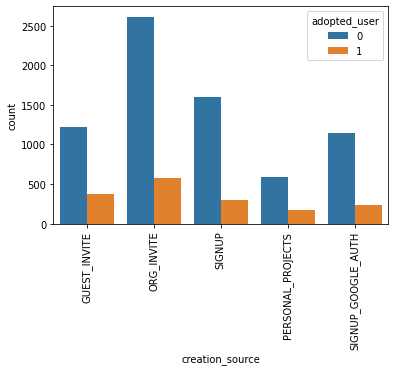

In [ ]:
a = sns.countplot(x='creation_source', data=data, hue='adopted_user')
a = plt.xticks(rotation=90)

In [ ]:
creation_source = pd.get_dummies(data['creation_source'], drop_first=True)
model_data = pd.concat([data, creation_source], axis=1).drop('creation_source', axis=1)
y = model_data['adopted_user']
X = model_data.drop('adopted_user', axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)


he most significant feature is clearly the user history. Based on this, I believe that encouraging existing users to log in and utilise the application after they've had accounts for a time might be an effective approach of increasing adopted users.

The second aspect to consider is how the user signed up (if you add the importances of the four signup features above). Guest invitations and personal projects are the two categories with the greatest user adoption rates among the methods people sign up.

Encouraging users to invite others and providing incentives for people to utilise the software to work on personal projects might be fairly beneficial.

Account age is important, but there is little that can be done about it.

Marketing drip and mailing lists are ineffective.